In [1]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import transformers

import zipfile
import os
import shutil
import pandas as pd
import torch
from PIL import Image
import torchvision
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.ops import box_convert, batched_nms
from tqdm.notebook import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
def extract_zip(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [5]:
dataset_path = '/content/drive/My Drive/MURA/MURA-v1.1.zip'
extract_path = '/content/'
extract_zip(dataset_path,extract_path)

In [6]:
# Define the mapping for 'class'
class_mapping = {
    'XR_ELBOW': 0,
    'XR_FINGER': 1,
    'XR_FOREARM': 2,
    'XR_HAND': 3,
    'XR_HUMERUS': 4,
    'XR_SHOULDER': 5,
    'XR_WRIST': 6
}

In [7]:
import pandas as pd

# Load the CSV file into a DataFrame (assuming your data is in 'data.csv')
df = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv', header=None, names=['path'])

# Add the 'fractured' column (1 for 'positive', 0 for 'negative')
df['fractured'] = df['path'].apply(lambda x: 1 if 'positive' in x else 0)


# Add the 'class' column based on the study type in the path
df['class'] = df['path'].apply(lambda x: class_mapping[x.split('/')[2]])

# Save the updated DataFrame to a new CSV
df.to_csv('processed_data_train.csv', index=False)

# Print the first few rows of the updated DataFrame


# All Dataset

In [8]:
import pandas as pd

df_train_studies = pd.read_csv('/content/MURA-v1.1/train_labeled_studies.csv', header=None, names=['path', 'label'])

df_val_studies = pd.read_csv('/content/MURA-v1.1/valid_labeled_studies.csv', header=None, names=['path', 'label'])


# Finger Only

In [9]:
df_train_finger = df_train_studies[df_train_studies['path'].str.contains('FINGER', case=False)]
df_val_finger = df_val_studies[df_val_studies['path'].str.contains('FINGER', case=False)]

df_train_finger

,path,label
3413,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,1
3414,MURA-v1.1/train/XR_FINGER/patient03228/study1_...,1
3415,MURA-v1.1/train/XR_FINGER/patient03229/study1_...,1
3416,MURA-v1.1/train/XR_FINGER/patient02370/study1_...,1
3417,MURA-v1.1/train/XR_FINGER/patient02370/study2_...,1
...,...,...
5343,MURA-v1.1/train/XR_FINGER/patient04898/study1_...,0
5344,MURA-v1.1/train/XR_FINGER/patient04899/study1_...,0
5345,MURA-v1.1/train/XR_FINGER/patient04900/study1_...,0
5346,MURA-v1.1/train/XR_FINGER/patient04901/study1_...,0


In [10]:
from sklearn.model_selection import train_test_split

# Assuming `df_finger` is your filtered DataFrame
# Stratify by the 'label' column to ensure balanced distribution
df_train_finger, df_test_finger = train_test_split(
    df_train_finger,
    test_size=0.2,
    stratify=df_train_finger['label'],
    random_state=42
)

# Print the size of the subsets
print(f"Training set size: {len(df_train_finger)}")
print(f"Testing set size: {len(df_test_finger)}")

# Optional: Check label distribution
print("Training label distribution:")
print(df_train_finger['label'].value_counts(normalize=True))
print("Testing label distribution:")
print(df_test_finger['label'].value_counts(normalize=True))

Training set size: 1548
Testing set size: 387
Training label distribution:
label
0    0.661499
1    0.338501
Name: proportion, dtype: float64
Testing label distribution:
label
0    0.661499
1    0.338501
Name: proportion, dtype: float64


In [11]:
print(len(df_train_finger))

1548


In [12]:
df_train_finger.to_csv('processed_finger_train.csv', index=False)
df_val_finger.to_csv('processed_finger_valid.csv', index=False)
df_test_finger.to_csv('processed_finger_test.csv', index=False)

In [13]:
albumentations_transform = A.Compose([
    A.Blur(p=0.1, blur_limit=(3, 7)),
    A.MedianBlur(p=0.1, blur_limit=(3, 7)),
    A.ToGray(p=0.1, method='weighted_average'),  # Weighted average method for grayscale
    A.CLAHE(p=0.1, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8)),
    A.Rotate(limit=(-30, 30), p=0.3),  # Random rotation between -30 and 30 degrees, applied with a probability of 50%
    A.HorizontalFlip(p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()  # Convert to PyTorch tensor
])

In [14]:
albumentations_transform_val = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()  # Convert to PyTorch tensor
])

In [15]:
from PIL import Image
import numpy as np
from torchvision import transforms

class FracturedDataset(Dataset):
    def __init__(self, csv_file, transform=None, image_size=(224, 224)):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size  # Add desired image size for resizing

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        images = []
        dir_path = row['path']
        for image_path in os.listdir(dir_path):
            image_path = os.path.join(dir_path, image_path)
            image = Image.open(image_path).convert("RGB")

            # Resize the image
            image = image.resize(self.image_size)

            # Apply transformations if specified
            if self.transform:
                transformed = self.transform(image=np.array(image))
                image = transformed['image']
            else:
                image = np.array(image)

            images.append(image)

        label = row['label']
        return dir_path, images, label


import torch
import numpy as np

import torch
import numpy as np

def collate_fn(batch):
    max_images = 5  # The fixed number of images per study

    dir_paths = []
    padded_images = []
    labels = []

    for dir_path, images, label in batch:
        dir_paths.append(dir_path)
        labels.append(label)

        # Pad with zero-filled images if the number of images is less than max_images
        padded_images_batch = images[:max_images]  # Truncate if more than max_images
        if len(images) < max_images:
            padding = [np.zeros_like(images[0]) for _ in range(max_images - len(images))]
            padded_images_batch.extend(padding)

        # Stack images into a single numpy array
        padded_images.append(np.stack(padded_images_batch, axis=0))  # Shape: [max_images, height, width, channels]

    # Convert the padded_images list to a PyTorch tensor
    padded_images = np.stack(padded_images, axis=0)  # Shape: [batch, max_images, height, width, channels]
    # The line below was causing the error because it incorrectly reorders dimensions.
    # padded_images = torch.tensor(padded_images).permute(0, 1, 4, 2, 3)  # Reorder to [batch, num_images, channels, height, width]
    # Change it to:
    padded_images = torch.tensor(padded_images).permute(0, 1, 2, 3, 4) # Reorder to [batch, num_images, channels, height, width]

    # Convert labels to a tensor
    labels = torch.tensor(labels)

    return dir_paths, padded_images, labels

In [16]:
seed_everything(42)
train_dataset = FracturedDataset(csv_file="processed_finger_train.csv", transform=albumentations_transform_val)
val_dataset = FracturedDataset(csv_file="processed_finger_valid.csv", transform = albumentations_transform_val)
test_dataset = FracturedDataset(csv_file="processed_finger_test.csv", transform = albumentations_transform_val)

In [17]:
import torch
import torchvision.models as models
from torchvision import transforms

# Load the ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Modify the final fully connected layer for 100 output features
num_ftrs = resnet18.fc.in_features  # Number of input features to the final layer
resnet18.fc = torch.nn.Linear(num_ftrs, 100)  # Update for 100 output features

# Move the modified model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18 = resnet18.to(device)

# Print the updated model architecture
print("Modified ResNet-18 with 100 output features:")
print(resnet18)

print("ResNet-18 model imported and customized successfully.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.7MB/s]


Modified ResNet-18 with 100 output features:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
import torch
import torch.nn as nn
from torchvision import models

class ResNetFeatureExtractor(nn.Module):
    def __init__(self, output_features=100):
        super(ResNetFeatureExtractor, self).__init__()
        # Load pre-trained ResNet-18
        self.resnet = models.resnet18(pretrained=True)

        # Modify the fully connected layer to output the desired number of features
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, output_features)

        # Define additional fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Linear(output_features * 5, 256),  # Concatenate features from 5 images
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),  # Output a single value
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        """
        x: Tensor of shape [batch_size, 5, 3, 224, 224]
        """
        batch_size, num_images, channels, height, width = x.shape

        # Reshape the input tensor correctly
        x = x.view(batch_size * num_images, channels, height, width)  # Shape: [batch_size * 5, 3, 224, 224]

        # Extract features for all images
        features = self.resnet(x)  # Shape: [batch_size * 5, output_features]

        # Reshape back to batch size
        features = features.view(batch_size, num_images, -1)  # Shape: [batch_size, 5, output_features]

        # Concatenate features from all 5 images
        concatenated_features = features.view(batch_size, -1)  # Shape: [batch_size, 5 * output_features]

        # Pass through the fully connected layers
        output = self.fc(concatenated_features)  # Shape: [batch_size, 1]

        return output

In [20]:
# Create DataLoader
seed_everything(42)
train_loader = DataLoader(
    train_dataset,
    batch_size=4,         # Set your desired batch size
    shuffle=True,          # Shuffle for training
    num_workers=2,         # Number of worker processes for loading data
    pin_memory=True,        # Pin memory for faster data transfer to GPU
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    val_dataset,
    batch_size=4,         # Set your desired batch size
    shuffle=False,          # Shuffle for training
    num_workers=2,         # Number of worker processes for loading data
    pin_memory=True,        # Pin memory for faster data transfer to GPU
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,         # Set your desired batch size
    shuffle=False,          # Shuffle for training
    num_workers=2,         # Number of worker processes for loading data
    pin_memory=True,        # Pin memory for faster data transfer to GPU
    collate_fn=collate_fn
)

In [21]:
for batch in train_loader:
  dirs, images, labels = batch
  print(images.shape)
  break

torch.Size([4, 5, 3, 224, 224])


In [22]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Initialize model, optimizer, and loss function
model = ResNetFeatureExtractor(output_features=100).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()  # Binary Cross-Entropy Loss

best_val_loss = float('inf')
best_model_path = "best_model.pth"

# Metrics tracking
metrics_history = {
    "train_loss": [],
    "val_loss": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "auc": []
}

# Training loop
for epoch in range(15):  # Number of epochs
    model.train()
    train_loss = 0
    all_train_labels = []
    all_train_preds = []

    # Training phase
    for batch in train_loader:
        dir_paths, inputs, labels = batch  # inputs: [batch_size, 5, 3, 224, 224], labels: [batch_size]
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        # Forward pass
        outputs = model(inputs).squeeze()  # Shape: [batch_size]
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect predictions for metrics
        preds = (outputs > 0.5).long().cpu().numpy()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds)

    train_loss /= len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_precision = precision_score(all_train_labels, all_train_preds)
    train_recall = recall_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds)

    # Validation phase
    model.eval()
    val_loss = 0
    all_val_labels = []
    all_val_preds = []
    all_val_probs = []

    with torch.no_grad():
        for batch in valid_loader:
            dir_paths, inputs, labels = batch  # inputs: [batch_size, 5, 3, 224, 224], labels: [batch_size]
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze()  # Shape: [batch_size]
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect predictions and probabilities for metrics
            preds = (outputs > 0.5).long().cpu().numpy()
            probs = outputs.cpu().numpy()  # Sigmoid output is already a probability
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds)
            all_val_probs.extend(probs)

    val_loss /= len(valid_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds)
    val_recall = recall_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds)
    val_auc = roc_auc_score(all_val_labels, all_val_probs)

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1-score: {train_f1:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1-score: {val_f1:.4f}, Val AUC: {val_auc:.4f}")

    # Save metrics
    metrics_history["train_loss"].append(train_loss)
    metrics_history["val_loss"].append(val_loss)
    metrics_history["accuracy"].append(val_acc)
    metrics_history["precision"].append(val_precision)
    metrics_history["recall"].append(val_recall)
    metrics_history["f1_score"].append(val_f1)
    metrics_history["auc"].append(val_auc)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  Best model saved with Val Loss: {best_val_loss:.4f}")

print("Training completed.")


Epoch 1:
  Train Loss: 0.5755, Train Accuracy: 0.6873, Train Precision: 0.5562, Train Recall: 0.3779, Train F1-score: 0.4500
  Val Loss: 0.6364, Val Accuracy: 0.7143, Val Precision: 0.8000, Val Recall: 0.5301, Val F1-score: 0.6377, Val AUC: 0.7854
  Best model saved with Val Loss: 0.6364
Epoch 2:
  Train Loss: 0.5137, Train Accuracy: 0.7513, Train Precision: 0.6691, Train Recall: 0.5248, Train F1-score: 0.5882
  Val Loss: 0.5867, Val Accuracy: 0.6800, Val Precision: 0.8857, Val Recall: 0.3735, Val F1-score: 0.5254, Val AUC: 0.8139
  Best model saved with Val Loss: 0.5867
Epoch 3:
  Train Loss: 0.4662, Train Accuracy: 0.7817, Train Precision: 0.7225, Train Recall: 0.5763, Train F1-score: 0.6412
  Val Loss: 0.6344, Val Accuracy: 0.7314, Val Precision: 0.9091, Val Recall: 0.4819, Val F1-score: 0.6299, Val AUC: 0.8303
Epoch 4:
  Train Loss: 0.4193, Train Accuracy: 0.8152, Train Precision: 0.7705, Train Recall: 0.6469, Train F1-score: 0.7033
  Val Loss: 0.6275, Val Accuracy: 0.7486, Val Pre

In [23]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load the best model
model = ResNetFeatureExtractor(output_features=100).to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode

# Initialize metrics
test_loss = 0
all_test_labels = []
all_test_preds = []
all_test_probs = []

# Testing loop
with torch.no_grad():
    for batch in test_loader:  # Assuming `test_loader` is defined
        dir_paths, inputs, labels = batch  # inputs: [batch_size, 5, 3, 224, 224], labels: [batch_size]
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        # Forward pass
        outputs = model(inputs).squeeze()  # Shape: [batch_size]
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Collect predictions and probabilities for metrics
        preds = (outputs > 0.5).long().cpu().numpy()
        probs = outputs.cpu().numpy()  # Sigmoid output is already a probability
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(preds)
        all_test_probs.extend(probs)

# Calculate average test loss
test_loss /= len(test_loader)

# Calculate test metrics
test_acc = accuracy_score(all_test_labels, all_test_preds)
test_precision = precision_score(all_test_labels, all_test_preds)
test_recall = recall_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds)
test_auc = roc_auc_score(all_test_labels, all_test_probs)

# Print test metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-23-e3ac9783c58a>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

Test Loss: 0.5132
Test Accuracy: 0.7416
Test Precision: 0.7719
Test Recall: 0.3359
Test F1-score: 0.4681
Test AUC: 0.8089


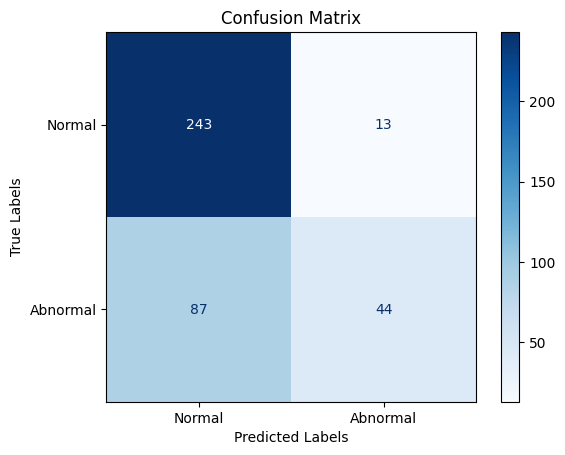

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(all_test_labels, all_test_preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format="d")

# Add title and labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [25]:
counts = {}
for _, _, label in test_dataset:
    if label not in counts:
        counts[label] = 0
    counts[label] += 1

print(counts)

{1: 131, 0: 256}


In [26]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class BalancedFracturedDataset(Dataset):
    def __init__(self, csv_file, transform=None, image_size=(224, 224)):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size

        # Oversample minority class (label == 1)
        class_1_indices = self.data[self.data['label'] == 1].index.tolist()
        oversampled_class_1 = self.data.loc[class_1_indices]
        self.balanced_data = pd.concat([self.data, oversampled_class_1], ignore_index=True)

        # Shuffle the dataset after oversampling
        self.balanced_data = self.balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

    def __len__(self):
        return len(self.balanced_data)

    def __getitem__(self, idx):
        row = self.balanced_data.iloc[idx]
        dir_path = row['path']
        label = row['label']

        images = []
        for image_path in os.listdir(dir_path):
            image_path = os.path.join(dir_path, image_path)
            image = Image.open(image_path).convert("RGB")
            image = image.resize(self.image_size)

            if self.transform:
                transformed = self.transform(image=np.array(image))
                image = transformed['image']
            else:
                image = np.array(image)

            images.append(image)

        return dir_path, images, label


In [27]:
seed_everything(42)
train_dataset = BalancedFracturedDataset(csv_file="processed_finger_train.csv", transform=albumentations_transform)
val_dataset = FracturedDataset(csv_file="processed_finger_valid.csv", transform = albumentations_transform_val)
test_dataset = FracturedDataset(csv_file="processed_finger_test.csv", transform = albumentations_transform_val)

In [28]:
counts = {}
for _, _, label in train_dataset:
    if label not in counts:
        counts[label] = 0
    counts[label] += 1

print(counts)

{1: 1048, 0: 1024}


In [29]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Initialize model, optimizer, and loss function
model = ResNetFeatureExtractor(output_features=100).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()  # Binary Cross-Entropy Loss

best_val_loss = float('inf')
best_model_path = "best_model_oversampling.pth"

# Metrics tracking
metrics_history = {
    "train_loss": [],
    "val_loss": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "auc": []
}

# Training loop
for epoch in range(15):  # Number of epochs
    model.train()
    train_loss = 0
    all_train_labels = []
    all_train_preds = []

    # Training phase
    for batch in train_loader:
        dir_paths, inputs, labels = batch  # inputs: [batch_size, 5, 3, 224, 224], labels: [batch_size]
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        # Forward pass
        outputs = model(inputs).squeeze()  # Shape: [batch_size]
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect predictions for metrics
        preds = (outputs > 0.5).long().cpu().numpy()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds)

    train_loss /= len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_precision = precision_score(all_train_labels, all_train_preds)
    train_recall = recall_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds)

    # Validation phase
    model.eval()
    val_loss = 0
    all_val_labels = []
    all_val_preds = []
    all_val_probs = []

    with torch.no_grad():
        for batch in valid_loader:
            dir_paths, inputs, labels = batch  # inputs: [batch_size, 5, 3, 224, 224], labels: [batch_size]
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze()  # Shape: [batch_size]
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect predictions and probabilities for metrics
            preds = (outputs > 0.5).long().cpu().numpy()
            probs = outputs.cpu().numpy()  # Sigmoid output is already a probability
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds)
            all_val_probs.extend(probs)

    val_loss /= len(valid_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds)
    val_recall = recall_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds)
    val_auc = roc_auc_score(all_val_labels, all_val_probs)

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1-score: {train_f1:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1-score: {val_f1:.4f}, Val AUC: {val_auc:.4f}")

    # Save metrics
    metrics_history["train_loss"].append(train_loss)
    metrics_history["val_loss"].append(val_loss)
    metrics_history["accuracy"].append(val_acc)
    metrics_history["precision"].append(val_precision)
    metrics_history["recall"].append(val_recall)
    metrics_history["f1_score"].append(val_f1)
    metrics_history["auc"].append(val_auc)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  Best model saved with Val Loss: {best_val_loss:.4f}")

print("Training completed.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Exception in thread Thread-44 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 59, 

KeyboardInterrupt: 

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load the best model
model = ResNetFeatureExtractor(output_features=100).to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode

# Initialize metrics
test_loss = 0
all_test_labels = []
all_test_preds = []
all_test_probs = []

# Testing loop
with torch.no_grad():
    for batch in test_loader:  # Assuming `test_loader` is defined
        dir_paths, inputs, labels = batch  # inputs: [batch_size, 5, 3, 224, 224], labels: [batch_size]
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        # Forward pass
        outputs = model(inputs).squeeze()  # Shape: [batch_size]
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Collect predictions and probabilities for metrics
        preds = (outputs > 0.5).long().cpu().numpy()
        probs = outputs.cpu().numpy()  # Sigmoid output is already a probability
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(preds)
        all_test_probs.extend(probs)

# Calculate average test loss
test_loss /= len(test_loader)

# Calculate test metrics
test_acc = accuracy_score(all_test_labels, all_test_preds)
test_precision = precision_score(all_test_labels, all_test_preds)
test_recall = recall_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds)
test_auc = roc_auc_score(all_test_labels, all_test_probs)

# Print test metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(all_test_labels, all_test_preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format="d")

# Add title and labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class ResNetFeatureExtractorWithTransformer(nn.Module):
    def __init__(self, output_features=100, num_heads=4, num_layers=2, hidden_dim=256):
        super(ResNetFeatureExtractorWithTransformer, self).__init__()
        # Load pre-trained ResNet-18
        self.resnet = models.resnet18(pretrained=True)

        # Modify the fully connected layer to output the desired number of features
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, output_features)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=output_features, nhead=num_heads, dim_feedforward=hidden_dim, dropout=0.1, activation="relu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Linear(output_features, 1),  # Output a single value
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        """
        x: Tensor of shape [batch_size, 5, 3, 224, 224]
        """
        batch_size, num_images, channels, height, width = x.shape

        # Flatten the input tensor to process images through ResNet
        x = x.view(batch_size * num_images, channels, height, width)  # Shape: [batch_size * 5, 3, 224, 224]

        # Extract features for all images
        features = self.resnet(x)  # Shape: [batch_size * 5, output_features]

        # Reshape back to batch size
        features = features.view(batch_size, num_images, -1)  # Shape: [batch_size, 5, output_features]

        # Transformer expects [sequence_length, batch_size, feature_dim]
        features = features.permute(1, 0, 2)  # Shape: [num_images, batch_size, output_features]

        # Pass features through Transformer Encoder
        transformer_output = self.transformer(features)  # Shape: [num_images, batch_size, output_features]

        # Aggregate the sequence output
        pooled_output = transformer_output.mean(dim=0)  # Shape: [batch_size, output_features]

        # Final classification
        output = self.classifier(pooled_output)  # Shape: [batch_size, 1]

        return output


In [ ]:
seed_everything(42)
train_dataset = FracturedDataset(csv_file="processed_finger_train.csv", transform=albumentations_transform)
val_dataset = FracturedDataset(csv_file="processed_finger_valid.csv", transform = albumentations_transform_val)
test_dataset = FracturedDataset(csv_file="processed_finger_test.csv", transform = albumentations_transform_val)

# Create DataLoader
seed_everything(42)
train_loader = DataLoader(
    train_dataset,
    batch_size=4,         # Set your desired batch size
    shuffle=True,          # Shuffle for training
    num_workers=2,         # Number of worker processes for loading data
    pin_memory=True,        # Pin memory for faster data transfer to GPU
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    val_dataset,
    batch_size=4,         # Set your desired batch size
    shuffle=False,          # Shuffle for training
    num_workers=2,         # Number of worker processes for loading data
    pin_memory=True,        # Pin memory for faster data transfer to GPU
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,         # Set your desired batch size
    shuffle=False,          # Shuffle for training
    num_workers=2,         # Number of worker processes for loading data
    pin_memory=True,        # Pin memory for faster data transfer to GPU
    collate_fn=collate_fn
)

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Initialize model, optimizer, and loss function
model = ResNetFeatureExtractorWithTransformer(output_features=100).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()  # Binary Cross-Entropy Loss

best_val_loss = float('inf')
best_model_path = "best_model_oversampling.pth"

# Metrics tracking
metrics_history = {
    "train_loss": [],
    "val_loss": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "auc": []
}

# Training loop
for epoch in range(15):  # Number of epochs
    model.train()
    train_loss = 0
    all_train_labels = []
    all_train_preds = []

    # Training phase
    for batch in train_loader:
        dir_paths, inputs, labels = batch  # inputs: [batch_size, 5, 3, 224, 224], labels: [batch_size]
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        # Forward pass
        outputs = model(inputs).squeeze()  # Shape: [batch_size]
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect predictions for metrics
        preds = (outputs > 0.5).long().cpu().numpy()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds)

    train_loss /= len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_precision = precision_score(all_train_labels, all_train_preds)
    train_recall = recall_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds)

    # Validation phase
    model.eval()
    val_loss = 0
    all_val_labels = []
    all_val_preds = []
    all_val_probs = []

    with torch.no_grad():
        for batch in valid_loader:
            dir_paths, inputs, labels = batch  # inputs: [batch_size, 5, 3, 224, 224], labels: [batch_size]
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze()  # Shape: [batch_size]
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect predictions and probabilities for metrics
            preds = (outputs > 0.5).long().cpu().numpy()
            probs = outputs.cpu().numpy()  # Sigmoid output is already a probability
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds)
            all_val_probs.extend(probs)

    val_loss /= len(valid_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds)
    val_recall = recall_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds)
    val_auc = roc_auc_score(all_val_labels, all_val_probs)

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1-score: {train_f1:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1-score: {val_f1:.4f}, Val AUC: {val_auc:.4f}")

    # Save metrics
    metrics_history["train_loss"].append(train_loss)
    metrics_history["val_loss"].append(val_loss)
    metrics_history["accuracy"].append(val_acc)
    metrics_history["precision"].append(val_precision)
    metrics_history["recall"].append(val_recall)
    metrics_history["f1_score"].append(val_f1)
    metrics_history["auc"].append(val_auc)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  Best model saved with Val Loss: {best_val_loss:.4f}")

print("Training completed.")


In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load the best model
model = ResNetFeatureExtractorWithTransformer(output_features=100).to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode

# Initialize metrics
test_loss = 0
all_test_labels = []
all_test_preds = []
all_test_probs = []

# Testing loop
with torch.no_grad():
    for batch in test_loader:  # Assuming `test_loader` is defined
        dir_paths, inputs, labels = batch  # inputs: [batch_size, 5, 3, 224, 224], labels: [batch_size]
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        # Forward pass
        outputs = model(inputs).squeeze()  # Shape: [batch_size]
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Collect predictions and probabilities for metrics
        preds = (outputs > 0.5).long().cpu().numpy()
        probs = outputs.cpu().numpy()  # Sigmoid output is already a probability
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(preds)
        all_test_probs.extend(probs)

# Calculate average test loss
test_loss /= len(test_loader)

# Calculate test metrics
test_acc = accuracy_score(all_test_labels, all_test_preds)
test_precision = precision_score(all_test_labels, all_test_preds)
test_recall = recall_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds)
test_auc = roc_auc_score(all_test_labels, all_test_probs)

# Print test metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(all_test_labels, all_test_preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format="d")

# Add title and labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
